# Implementing ANNs with Tensorflow
## Homework 1 - 4/11/17
#### Auss Abbood, John Berroa, Luke Effenberger

# Part 1
Watched.
# Part 2
1. Network Function: 

 $$y=\sigma(\sigma(\sigma(\overline{x}^TW_1)W_2)\overline{w}_3)$$

2. Loss Function: 

 $$SumSquaredError=\sum_i\frac{1}{2}(\hat{y_i}-\sigma(\sigma(\sigma(\overline{x_i}^TW_1)W_2)\overline{w}_3))^2$$

3. Gradient of the Error function with respect to the output weight vector:

$$\nabla_{w_{out}}=\sum_i(\hat{y_i}-y_i)\cdot -\sigma '(\sigma(\sigma(\overline{x_i}^TW_1)W_2)\overline{w_3})\cdot \sigma(\sigma(\overline{x_i}^TW_1)W_2)$$

4. Derivative of the Logistic Function:

 $$\sigma'(x)= \frac{e^{-x}}{(e^{-x}+1)^2} = \sigma(x) \cdot (1-\sigma(x))$$
 
# Part 3

In [1]:
# 3.1-3.3 Import dependencies and generate cats and dogs data
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
%matplotlib notebook

sample_size = 30
np.random.seed(1)
cats = np.random.normal(25, 5, (2, sample_size)) 
dogs = np.random.normal(45, 15, (2, sample_size))

In [2]:
#3.4 Investigating the data
def scatter_data (arr1, arr2, title):
    """
    Creates a scatter plot showing the relation between height
    and length.
    Params:
    arr1, arr2: input 1 dimensional arrays
    title: plot title
    """
    plt.scatter(arr1[0], arr1[1], label='Dogs', c='orange')
    plt.scatter(arr2[0], arr2[1], label='Cats', c='blue')
    plt.xlabel('Length')
    plt.ylabel('Height')
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
def normalize(arr1, arr2):
    """
    Normalize the cat and dog data by using the entire dataset's mean and stddev
    Params:
    arr1, arr2: the two arrays to be normalized
    Returns:
    arr1_norm, arr2_norm: the normalized arrays
    """
    conc_arr = np.concatenate((arr1,arr2))
    arr1_norm = (arr1-np.mean(conc_arr))/np.std(conc_arr)
    arr2_norm = (arr2-np.mean(conc_arr))/np.std(conc_arr)
    return arr1_norm, arr2_norm

<IPython.core.display.Javascript object>


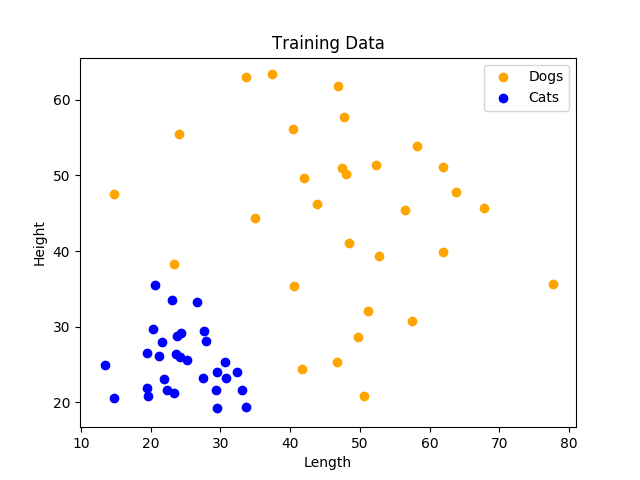

In [4]:
scatter_data(dogs, cats,'Training Data')

<IPython.core.display.Javascript object>


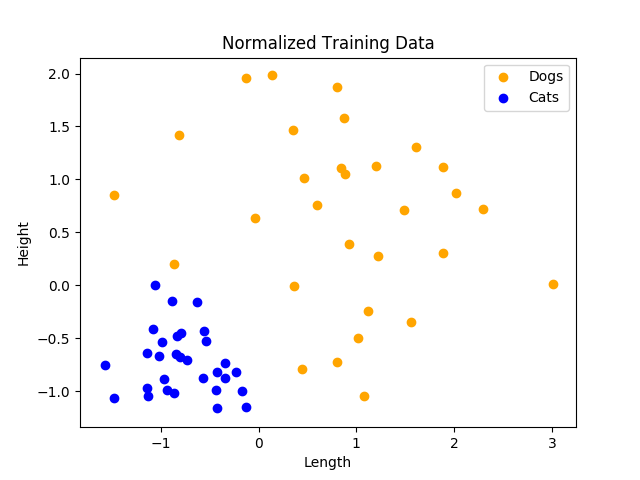

In [5]:
plt.figure(2)
scatter_data(*normalize(dogs,cats),'Normalized Training Data')

In [6]:
dogs, cats = normalize(dogs, cats)
data = np.concatenate((dogs, cats),axis=1) # combine cats and dogs into one variable

3.5 Activation function and target values

We choose the Logistic Function, since we will be doing a binary classification. We only have two outputs in this universe, dog or cat.  If there were other animals that we could possibly learn about later on, the "either cat or dog" structure wouldn't work.  But in this case, it is essentially a heads/tails problem.

In [7]:
def gen_targets(d, size):
    """
    Generates the targets for the dataset, where the first 30 entries are labeled 1 (dog) and the rest are 0 (cat)
    Params:
    d: entire dataset
    size: number of dogs (assumes dogs and cats are equal in number)
    Returns:
    targets: The target value as a column array
    """
    targets = np.zeros(d.shape[1])
    targets[:size] = 1
    targets = np.expand_dims(targets, axis=1)
    return targets
    
targets = gen_targets(data, sample_size)
data = data.T

3.6-3.8 Forwardpropagation, Loss, and Backprop

We created a neural network class that nicely handles all the computations in functions and saves the values for analysis later.

In [14]:
class Neural_Network:
    def __init__(self, lr=.0001, weights=-2.5, momentum=0.0):
        self.activation = lambda x: 1/(1+np.exp(-x))  # logistic function
        self.activation_derivative = lambda x: self.activation(x) * (1-self.activation(x))
        self.learning_rate = lr
        self.W = np.ones((2,1)) * weights  # is changeable if so desired through the weights parameter
        self.losses = []  # to save losses for plotting
        self.weights = np.zeros((2,1000))
        self.weights[:,0:1] = self.W
        self.momentum = momentum

    def forward_propagate(self, x, custom_weight='empty'):
        """
        Forward propagates the input through the only neuron.  Can also forward prop on custom given weights.
        Params:
        x: data
        custom_weight: if given, will use these weights for the forward prop
        Returns:
        y: output
        """
        # if we want to use custom weights and not the self.W weights, we go into this condition
        if not isinstance(custom_weight, str):
            weight = np.ones((2,1))
            weight[0] = custom_weight[0]
            weight[1] = custom_weight[1]
            self.drive = np.dot(x, weight)
            y = self.activation(self.drive)
            return y
        else:  # use the network's weights
            self.drive = np.dot(x, self.W)  # weighted sums of input*weight
            y = self.activation(self.drive)  # activation of drive
            return y
    
    def loss_func(self, output, label, ignore=False):
        """
        Sum of squared errors loss function. Returns as well as saves the loss calculated.
        Params:
        output: the forwardprop output
        label: the proper label for the output
        ignore: if true, ignores appending losses
        Returns:
        loss: the calculated loss
        """
        loss = np.sum(0.5 * (label - output)**2)  # sum of squared errors
        if not ignore:
            self.losses.append(loss)
        return loss
    
    def back_prop(self, output, label, x):      
        """
        Backprops the error through the network
        Params:
        output: the forwardprop output
        label: the proper label for the output
        x: the data input into the network
        Returns:
        delta: the change in weights
        """
        delta = -np.dot(x.T, np.multiply((label - output), self.activation_derivative(self.drive))) 
        return delta
    
    def grad_descent(self, delta, step):
        """
        Changes the weights in the direction away from the gradient (step downhill)
        Params:
        delta: the change in the weights
        step: what step in the epoch we currently are in
        """
        self.weights[:, step+1:step+2] = self.W     
        self.W -= self.learning_rate * delta + self.momentum * (self.weights[:,step]-self.weights[:,step-1]).reshape(2,1)            

                 
    def learn(self, label, data, epochs, batchsize='batch'):
        """
        Trains the network in either batch, mini-batch, or stochastic mode.  
        This is determined by what is input into the batchsize variable.  Learns for e epochs.
        Params:
        label: the targets for the outputs
        data: the data going into the network
        epochs: number of runs through the entire dataset to train on
        batchsize: if nothing, will do the entire batch, if a number, will use that as batchsize
        """
        if batchsize == 'batch': # batch learning (default)
            for e in range(epochs):
                output = self.forward_propagate(data)
                loss = self.loss_func(output, label)
                delta = self.back_prop(output, label, data)
                self.grad_descent(delta, e)
        else: # minibatch learning if batchsize > 1, or stochastic learning if batchsize = 1
            e = 0  # current epoch count
            i = 0  # current iteration
            while e < epochs:
                for i in range(data.shape[0] // batchsize):  # step through all data
                    indicies = np.random.choice(np.arange(0, data.shape[0]), batchsize, replace=False)  #implicity shuffles data
                    output = self.forward_propagate(data[indicies])
                    delta = self.back_prop(output, label[indicies], data[indicies])
                    self.grad_descent(delta, e)
                loss = self.loss_func(output, label[indicies])  # only record loss after an epoch
                e += 1
    
                
    def loss_plots(self, dat, tgts, epochs):
        """
        Creates an error surface plot by brute forcing all weight values
        Params:
        dat: the data used to make the plot, e.g. all data for a batch surface, or 1 data point for its individual error surface
        tgts: the targets for calculating cost
        epochs: number of epochs to be trained
        """
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        
        for e in range(epochs):
            # Plot error surface
            plt.sca(ax[0])
            ax[0].cla()
            ax[0].set_title("Error Surface")
            ax[0].set_xlabel("Weight 1")
            ax[0].set_ylabel("Weight 2")
            x_range = y_range = np.linspace(-7,7, 50) #these numbers can be altered for more/less definition
            plot_losses = []
            for x in x_range:
                for y in y_range:
                    output = self.forward_propagate(dat, (x, y))
                    plot_losses.append(self.loss_func(output, tgts, True))
            X, Y = np.meshgrid(x_range, y_range)
            Z = np.reshape(plot_losses, (len(x_range), len(y_range)))
            cp = plt.contourf(X, Y, Z, cmap = "viridis", levels=np.linspace(.5, 29, 50))
            # plot contour lines
            plt.contour(X, Y, Z, colors = "black", linestyles = "dashed")
            if e == 1:
                plt.colorbar(cp) # add color-bar to figure        

            # Transform losses into easier to handle array
            self.losses = np.asarray(self.losses)
            # Plot the white line showing the path of the weights over time
            plt.plot(self.weights[0,0:e], self.weights[1,0:e], "w-")

            # Plot losses over time in second plot
            plt.sca(ax[1])
            ax[1].cla()
            ax[1].set_title("Loss Over Epochs")
            ax[1].set_xlabel("Epochs")
            ax[1].set_ylabel("Loss")
            x_vals = np.arange(0, epochs)
            y_vals = [0] * epochs
            y_vals[:e] = self.losses[:e]
            plt.plot(x_vals, y_vals)

            plt.tight_layout()
            
            fig.canvas.draw()
            sleep(.05)

Let's examine how the network works with the given weights of -2.5 for both $w_1$ and $w_2$:

<IPython.core.display.Javascript object>


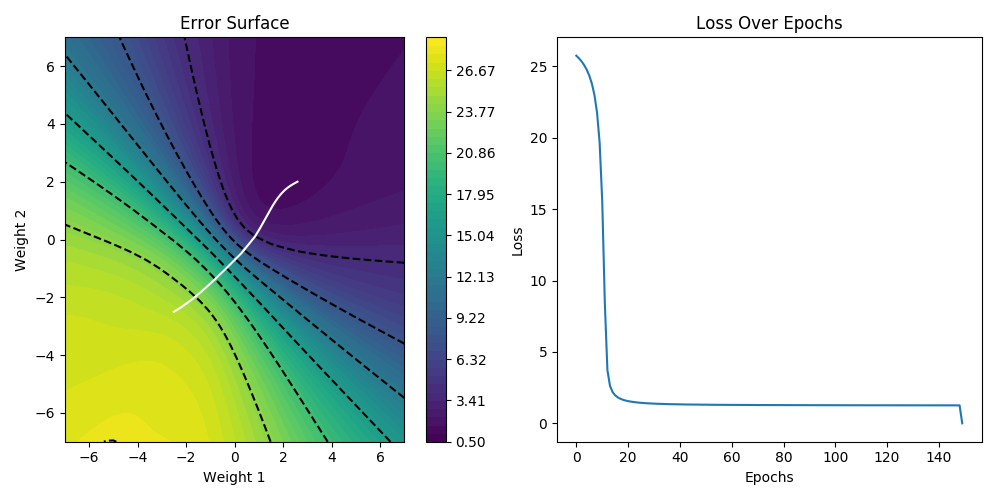

In [9]:
epochs = 150
cats_dogs_network = Neural_Network(.1)
cats_dogs_network.learn(targets, data, epochs)
cats_dogs_network.loss_plots(data, targets, epochs)

3.9 Gradient Descent

Now that the network is created, we will train it with various learning methodologies (batch, minibatch, and stochastic), as well as different learning rates, and plot the results.  We already know a learning rate of .1 works, so we'll try 1 and .01.

Learning Rate:  1
Method: Batch


<IPython.core.display.Javascript object>


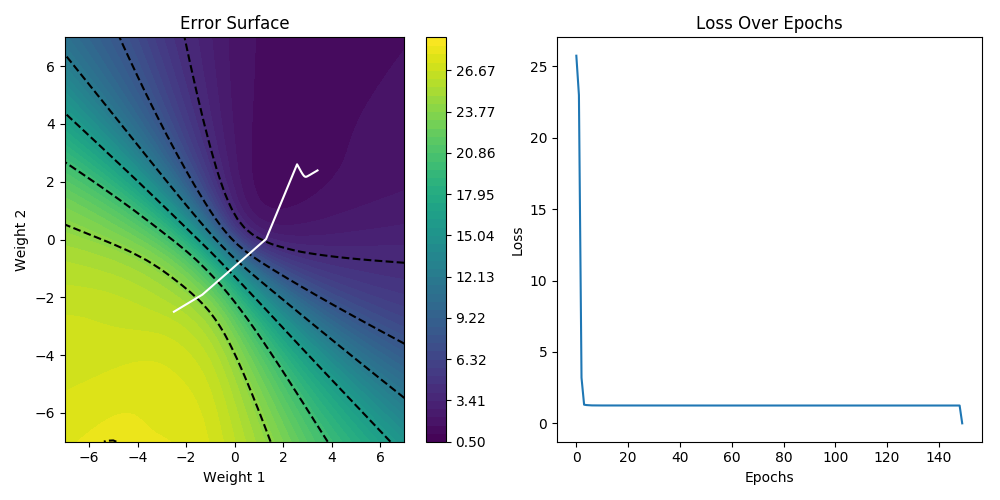

Learning Rate:  0.01
Method: Batch


<IPython.core.display.Javascript object>


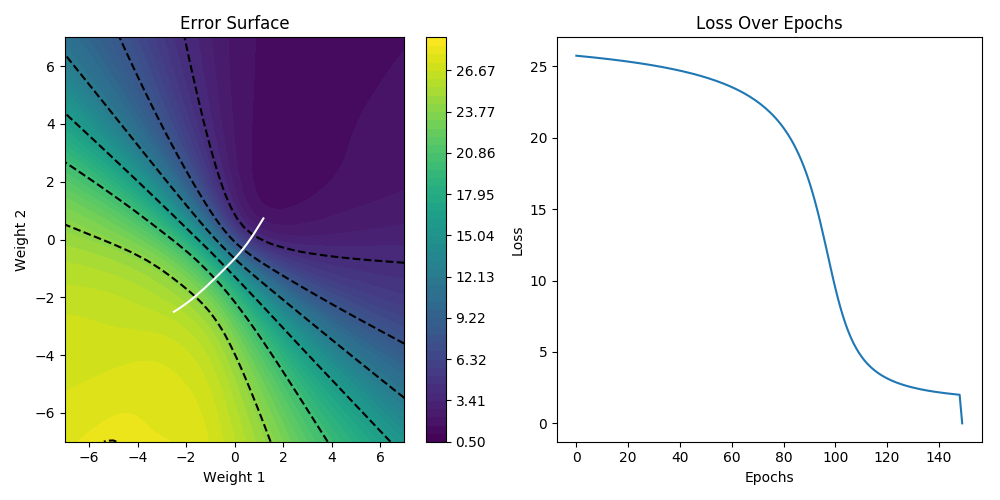

Learning Rate:  1
Method: Mini-Batch (10)


<IPython.core.display.Javascript object>


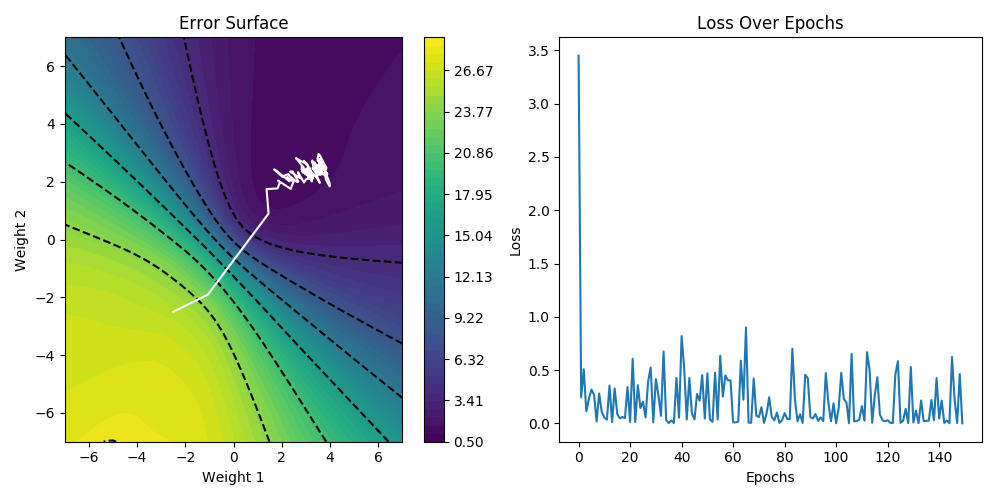

Learning Rate:  0.01
Method: Mini-Batch (10)


<IPython.core.display.Javascript object>


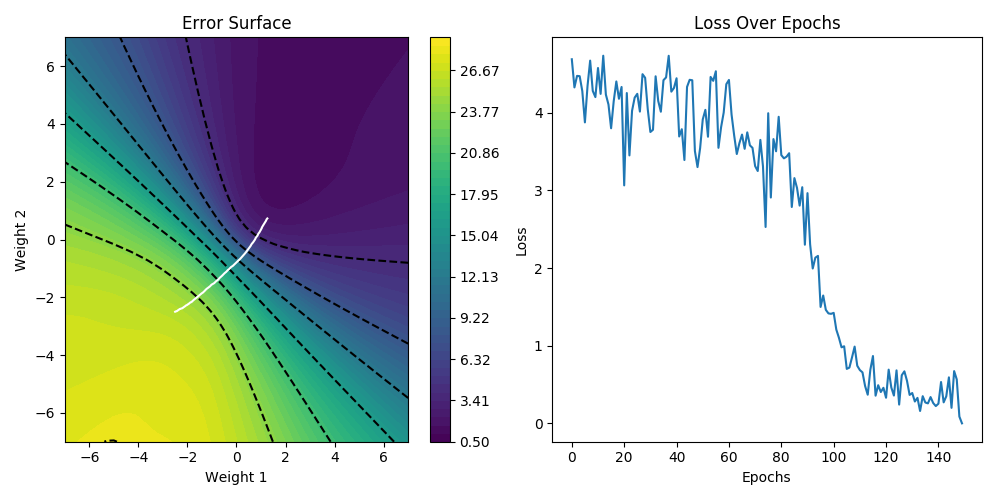

Learning Rate:  1
Method: Stochastic


<IPython.core.display.Javascript object>


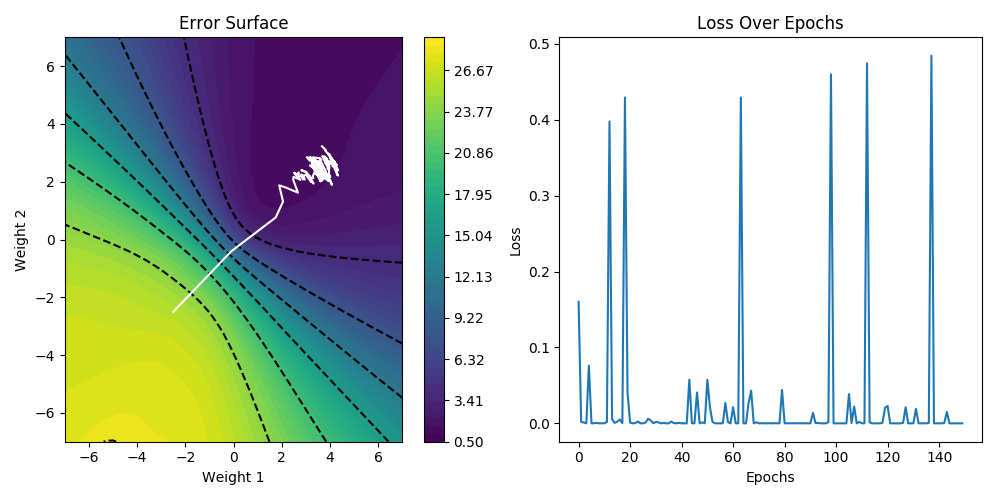

Learning Rate:  0.01
Method: Stochastic


<IPython.core.display.Javascript object>


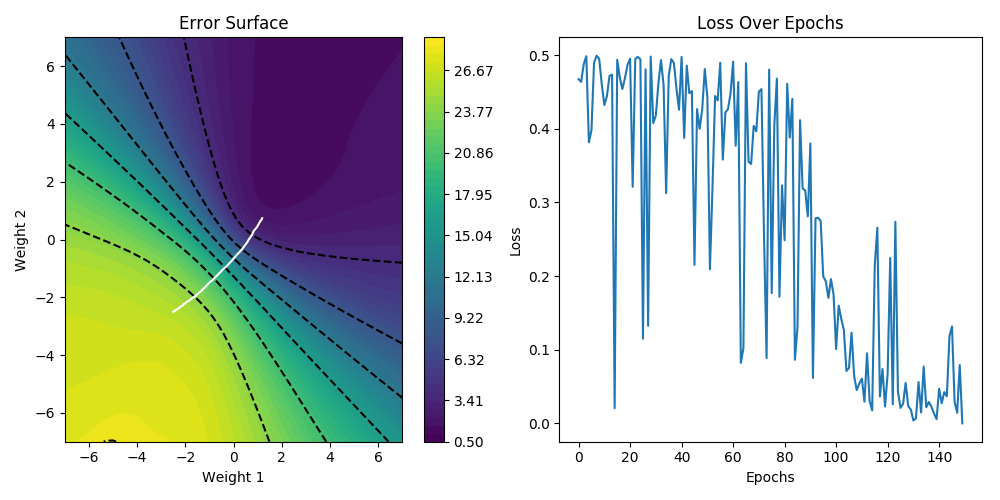

In [10]:
epochs = 150
learning_rates = [1,0.01]


for l in learning_rates:
    print("Learning Rate: ", l)
    print("Method: Batch")
    cats_dogs_network = Neural_Network(l)
    cats_dogs_network.learn(targets, data, epochs)
    cats_dogs_network.loss_plots(data, targets, epochs)
    
for l in learning_rates:
    print("Learning Rate: ", l)
    print("Method: Mini-Batch (10)")
    cats_dogs_network = Neural_Network(l)
    cats_dogs_network.learn(targets, data, epochs, batchsize=10)
    cats_dogs_network.loss_plots(data, targets, epochs)
    
for l in learning_rates:
    print("Learning Rate: ", l)
    print("Method: Stochastic")
    cats_dogs_network = Neural_Network(l)
    cats_dogs_network.learn(targets, data, epochs, batchsize=1)
    cats_dogs_network.loss_plots(data, targets, epochs)

Because the .01 learning rate was rather boring, we ran one more test with .1 and stochastic gradient descent, which turns out to be slightly more interesting.  It seems to maybe converge 1 or 2 steps faster than batch.

<IPython.core.display.Javascript object>


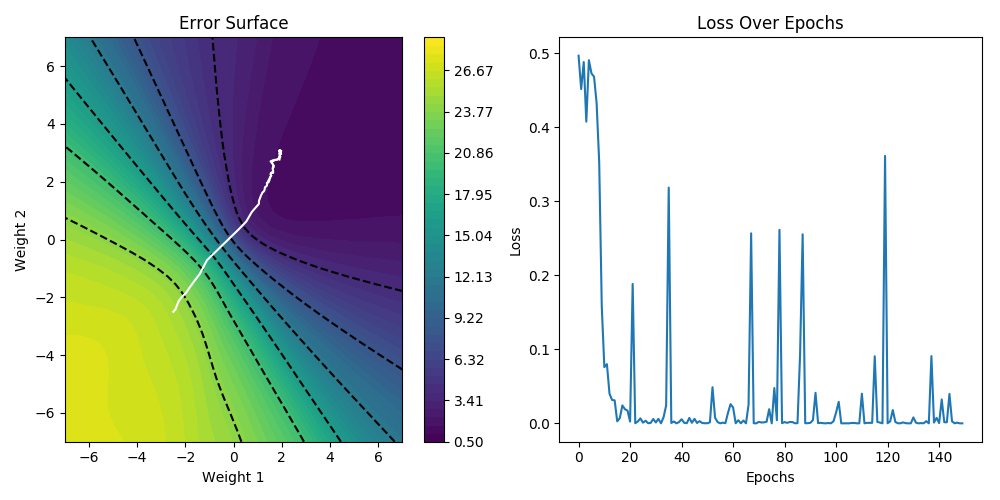

In [13]:
epochs = 150
cats_dogs_network = Neural_Network(.1)
cats_dogs_network.learn(targets, data, epochs, batchsize=1)
cats_dogs_network.loss_plots(data, targets, epochs)

As we can see, a learning rate of 1 is incredibly fast for this problem, and creates a lot of unnecessary jumping in the non-batch mode cases (however, it is also the fastest way to get to the minimum, in essentially ~2 steps).  A learning rate of .01 is too slow (for example, the batch training with .01 learning rate didn't reach the minimum in 150 steps, but was very close).

# Part 5

Now we'll add momentum, via the following formula:

$$w_{t+1} = w_t - \eta \nabla_w + \varepsilon \Delta w_{t-1;t}$$

This formula essentially says, add some percentage of the change in weights between the last step and the current step to the gradient calculation.

This allows the gradient descent to behave as if it had momentum (obviously), like a ball rolling down a hill and gaining speed.  Below is momentum at .5 (compare with first graph above).

<IPython.core.display.Javascript object>


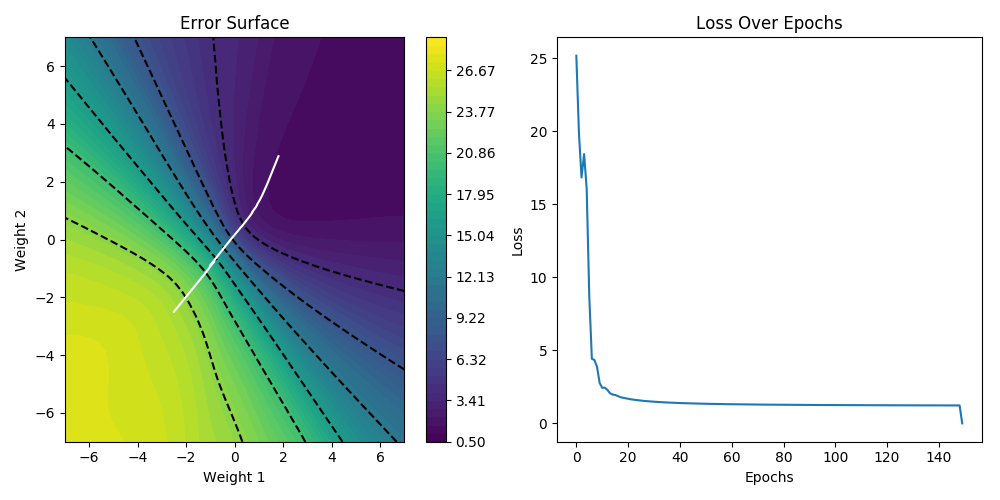

In [15]:
cats_dogs_network = Neural_Network(0.1, momentum=.5)
cats_dogs_network.learn(targets, data, epochs)
cats_dogs_network.loss_plots(data, targets, epochs)

# Part Fun
For fun, we will also check the accuracy of our model on unseen test data.  To do this, we will choose a new random seed, and classify with our trained network the new data.  Then, we will calculate the accuracy.

In [12]:
# most of the code here just repeats the preprocessing steps from above for the new random seed
sample_size = 30
np.random.seed(7)
cats = np.random.normal(25, 5, (2, sample_size)) 
dogs = np.random.normal(45, 15, (2, sample_size))
dogs, cats = normalize(dogs, cats)
data = np.concatenate((dogs, cats),axis=1) # combine cats and dogs into one variable
targets = gen_targets(data, sample_size)
data = data.T
predictions = cats_dogs_network.forward_propagate(data)
wrong = 0
unsure = 0
for i in range(len(predictions)):  # if the prediction is almost certain, make it one or 0, otherwise .5
    if predictions[i] > .8:
        predictions[i] = 1
        if predictions[i] != targets[i]:
            wrong += 1
    elif predictions[i] < .2:
        predictions[i] = 0
        if predictions[i] != targets[i]:
            wrong += 1
    else:
        predictions[i] = .5
        unsure += 1
print("The network got {} wrong, for an accuracy of {}%.".format(wrong, (1-(wrong/(sample_size*2)))*100))
print("The network was unsure about {} samples.".format(unsure))
print("\n\nNote: this test will use the last network trained with the name 'cats_dogs_network'!")

The network got 3 wrong, for an accuracy of 95.0%.
The network was unsure about 4 samples.


Note: this test will use the last network trained with the name 'cats_dogs_network'!
